In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Load the prepared data
We will load the prepared insurance dataset.

In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/Insurance fraud detection/dataset/insurance_data_prepared.csv'
df = pd.read_csv(file_path)

df.head()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,...,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,auto_make_Volkswagen
0,328,48,1000,1406.91,0,466132,53300,0,5,1,...,False,False,False,False,False,False,True,False,False,False
1,228,42,2000,1197.22,5000000,468176,0,0,8,1,...,False,False,False,False,True,False,False,False,False,False
2,134,29,2000,1413.14,5000000,430632,35100,0,7,3,...,True,False,False,False,False,False,False,False,False,False
3,256,41,2000,1415.74,6000000,608117,48900,-62400,5,1,...,False,False,False,False,False,False,False,False,False,False
4,228,44,1000,1583.91,6000000,610706,66000,-46000,20,1,...,False,False,False,False,False,False,False,False,False,False


# Split the Data into Training and Testing Sets

In [3]:
from sklearn.model_selection import train_test_split

y = df['fraud_reported']
X = df.drop('fraud_reported',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost Model

XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting algorithm. What differentiates it from other boosting algorithms is its speed and accuracy.

Let's import all the required libraries for training the model and plotting our graphs.

In [4]:
!pip install bayesian-optimization
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from bayes_opt import BayesianOptimization
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd

We will use Bayesian Optimization for hyperparameter tuning. Bayesian optimization builds a model for the optimization function and explores the parameter space systematically, which is a smart and much faster way to find the parameters.

Let's define our hyperparameter bounds and optimization function.


In [5]:
def f_optimize(
    learning_rate,
    n_estimators,
    max_depth,
    subsample,
    gamma,
    reg_alpha,
    reg_lambda,
    colsample_bytree,
    max_leaves,
    max_bin,
    scale_pos_weight,
):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    max_bin = int(max_bin)
    max_leaves = int(max_leaves)

    clf = xgb.XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        subsample=subsample,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        colsample_bytree=colsample_bytree,
        max_leaves=max_leaves,
        max_bin=max_bin,
        scale_pos_weight=scale_pos_weight,
    )
    return np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring="roc_auc"))


pbounds = {
    "learning_rate": (0.01, 0.01),
    "n_estimators": (1000, 1500),
    "max_depth": (3, 10),
    "subsample": (0.8, 0.9),
    "gamma": (4, 5),
    "reg_alpha": (0.5, 1),
    "reg_lambda": (0.5, 1),
    "colsample_bytree": (0.8, 1),
    "max_leaves": (8, 12),
    "max_bin": (60, 70),
    "max_depth": (3, 5),
    "scale_pos_weight": (1.4, 2),
}

optimizer = BayesianOptimization(
    f=f_optimize,
    pbounds=pbounds,
    random_state=42,
)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | colsam... |   gamma   | learni... |  max_bin  | max_depth | max_le... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.8693    | 0.8749    | 4.951     | 0.01      | 65.99     | 3.312     | 8.624     | 1.029e+03 | 0.9331    | 0.8006    | 1.825     | 0.8021    |
| 2         | 0.8727    | 0.994     | 4.832     | 0.01      | 61.82     | 3.367     | 9.217     | 1.262e+03 | 0.716     | 0.6456    | 1.767     | 0.8139    |
| 3         | 0.8714    | 0.8584    | 4.366     | 0.01      | 67.85     | 3.399     | 10.06     | 1.296e+03 | 0.5232    | 0.8038    | 1.502     | 0.8065    |
| 4         | 0.8719    | 0.9898    | 4.966     | 0.01      | 63.05     | 3.195     | 10.74     | 1.22e+03  | 0.561     | 0.7476    | 1.421     | 0.8909    |
| 5         | 0.8682    | 0.8518    | 4.663     | 0.

Now we build train the model with hyperparameters derived from previous step. We also enable early stopping feature of XGBoost to get the best iteration. Finally we plot its learning rate.

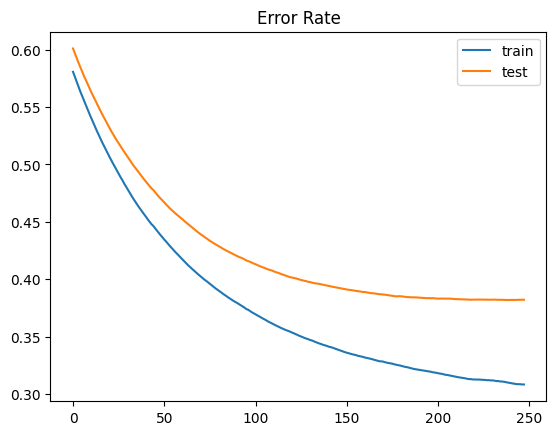

Test Accuracy: 83.50%


In [6]:
def xgb_train(X_train, y_train, X_test, y_test, params):
  xgb_model = xgb.XGBClassifier(random_state=42,**params)
  eval_set = [(X_train, y_train),(X_test, y_test)]
  xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

  return xgb_model

params = optimizer.max['params']
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params['eval_metric'] = 'logloss'
params['max_bin'] = int(params['max_bin'])
params['max_leaves'] = int(params['max_leaves'])
params['early_stopping_rounds'] = 10


xgb_model = xgb_train(X_train, y_train, X_test, y_test, params)
y_pred = xgb_model.predict(X_test)

results = xgb_model.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.title("Error Rate")
plt.savefig('/content/drive/MyDrive/Insurance fraud detection/results/xgboost_learning_curve.png')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

# Results

We plot confusion matrix, ROC curve, feature importance map and classification report for our model.

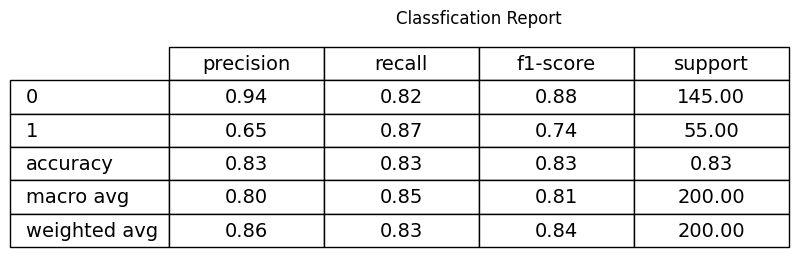

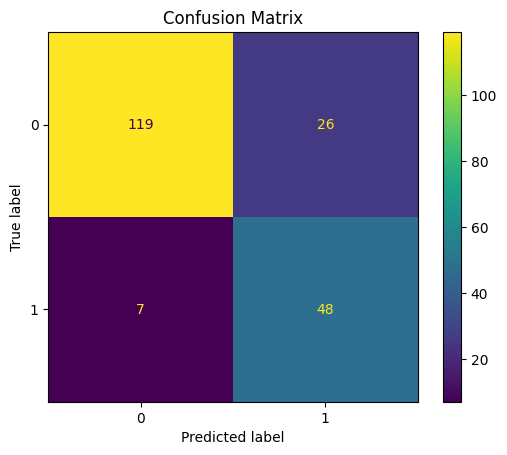

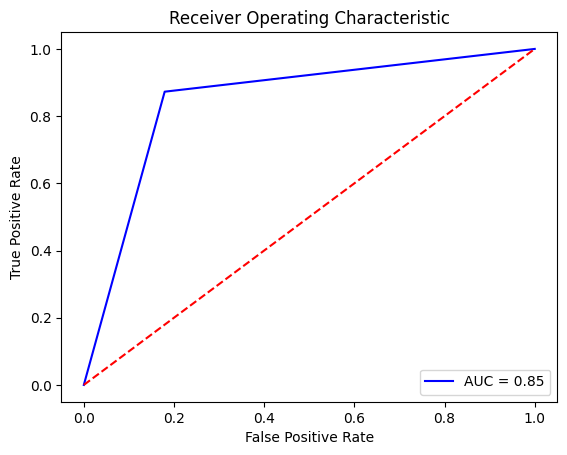

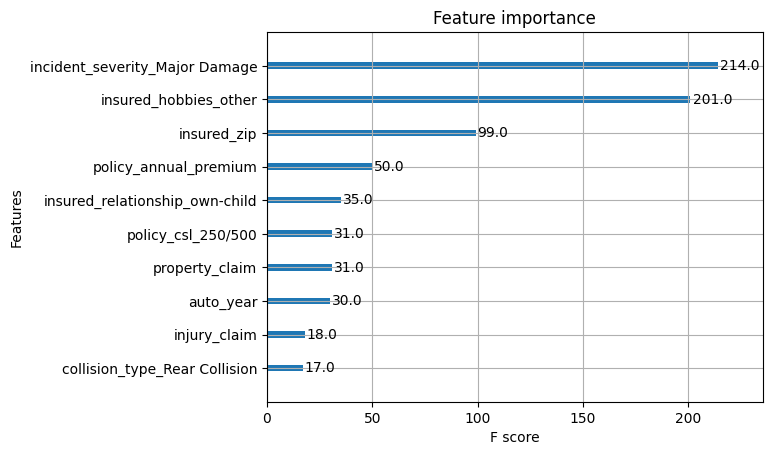

In [7]:
def plot_conf_matrix(y_test, y_pred):
  disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
  plt.title('Confusion Matrix')
  plt.savefig('/content/drive/MyDrive/Insurance fraud detection/results/xgboost_conf_matrix.png')
  plt.show()

def plot_roc(y_test,y_pred):
  fpr, tpr, threshold = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.gcf().savefig('/content/drive/MyDrive/Insurance fraud detection/results/xgboost_roc.png')
  plt.show()

def plot_feature_imp(xgb_model):
  xgb.plot_importance(xgb_model, max_num_features=10)
  plt.savefig('/content/drive/MyDrive/Insurance fraud detection/results/xgboost_feature_importance.png',bbox_inches="tight")
  plt.show()

def gen_classification_report(y_test, y_pred):
  class_report = classification_report(y_test, y_pred, output_dict=True)
  class_report_df = pd.DataFrame(class_report).transpose()
  class_report_df.update(class_report_df.applymap('{:,.2f}'.format))
  fig = plt.figure(figsize = (8, .2))
  ax = fig.add_subplot(111)
  tb = ax.table(cellText = class_report_df.values, rowLabels = class_report_df.index, colLabels = class_report_df.columns, cellLoc='center')
  tb.scale(1, 2)
  tb.auto_set_font_size(False)
  tb.set_fontsize(14)
  ax.set_title('Classfication Report')
  ax.axis('off')
  plt.savefig('/content/drive/MyDrive/Insurance fraud detection/results/xgboost_classification_report.png',bbox_inches="tight")
  plt.show()

gen_classification_report(y_test,y_pred)
plot_conf_matrix(y_test,y_pred)
plot_roc(y_test,y_pred)
plot_feature_imp(xgb_model)
plt.show()


# Save the model

Finally we save the model, ready for furthur inference.

In [8]:
model_path = '/content/drive/MyDrive/Insurance fraud detection/models/xgboost_model.json'
xgb_model.save_model(model_path)

print(f'Model saved to {model_path}')

Model saved to /content/drive/MyDrive/Insurance fraud detection/models/xgboost_model.json
